In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import textwrap 

# Some tools for writing, reading and joining LOWDIN potentials

In [29]:
def write_potential_to_lowdin_format(potentialName,species,angularMomentum,exponents,coefficients,centers):
    
    outFile = open(potentialName, "w")
    
    outFile.write("O-"+species+"\n")
    outFile.write("#\n")
    outFile.write("%i\n" % (len(exponents)))
    
    for i in range(0,len(exponents)) :
        outFile.write( str(i+1) + " "+ str(int(angularMomentum[i]))+"\n" )
        outFile.write( "%.8f %.8e\n" % (exponents[i], coefficients[i]) )
        
        aux = str(centers[i][0])+" "+str(centers[i][1])+" "+str(centers[i][2])
    
        outFile.write( aux + "\n")

    outFile.close()

    
def read_lowdin_potential(potentialFile):
    
    exponents = []
    coefficients = []
    angular_momentum = []
    centers = []
    
    
    potential = open(potentialFile, 'r')
    lines_pot = potential.readlines()
    num_gauss_pot = int(lines_pot[2])
    
    species_line = lines_pot[0].strip()
    species = str(species_line[2])+str(species_line[3])
    
    for i in range(3, len(lines_pot),3):
        angular_momentum.append(int(lines_pot[i].split()[1]))
    
    for i in range(4,len(lines_pot),3):
        exponents.append(float(lines_pot[i].split()[0]))
        coefficients.append(float(lines_pot[i].split()[1]))
    
    for i in range(5, len(lines_pot),3):
        centers.append([lines_pot[i].split()[0],lines_pot[i].split()[1],lines_pot[i].split()[2]])
    
    return species, num_gauss_pot, angular_momentum, exponents, coefficients, centers     
    

def join_lowdin_potentials(first_potential, second_potential, resulting_potential):
    
    fp = read_lowdin_potential(first_potential)
    sp = read_lowdin_potential(second_potential)
    
    species = fp[0]
    resulting_gaussians = fp[1] + sp[1]
    angular_momentum = [*fp[2],*sp[2]]
    exponents = [*fp[3],*sp[3]]
    coefficients = [*fp[4],*sp[4]]
    centers = [*fp[5],*sp[5]]
    
    write_potential_to_lowdin_format(resulting_potential,species,angular_momentum,exponents,coefficients,centers)
    

# A function for constructing the gaussian sums used to fit

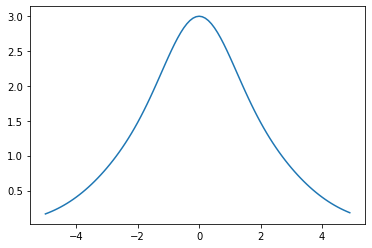

In [81]:
def create_python_function(name, body, parameters):
    
    exec(f"def {name}({parameters}):\n   {body}")
    
    return locals()[name]


def create_parameters(n):
    
    variable = "r"
    coefficients = []
    exponents = []
    
    
    for i in range(0,n):
        coefficients.append("a_"+str(i))
        exponents.append("b_"+str(i))
   
    return coefficients,exponents


def create_gaussians(name,coefficients,exponents,center):
    
    total_parameters_list = [*coefficients, *exponents]
    total_parameter_length = len(total_parameters_list)

    fitting_function = ""
    parameters = "r, "
    
    for i in range(0,len(coefficients)):
        if( i != len(coefficients)-1):
            fitting_function += f"{coefficients[i]}*np.exp(-{exponents[i]}*(r-{center})**2) + "
        else:
            fitting_function += f"{coefficients[i]}*np.exp(-{exponents[i]}*(r-{center})**2)"
    
    for i in range(0, total_parameter_length):
        if(i != total_parameter_length-1):
            parameters += f"{total_parameters_list[i]}, "
        else:
            parameters += f"{total_parameters_list[i]}"
    
    
    
    function_body = textwrap.dedent(f'''\
        return {fitting_function}
    ''')
    
    return create_function(name, function_body, parameters) 



### A little example of the use of this functions
"""
var = create_parameters(2)
    
A = create_gaussians("patito",var[0],var[1],0)
plt.figure()
plt.plot(np.arange(-5,5,0.1), A(np.arange(-5,5,0.1),2,1,0.1,0.5))
plt.show()
"""

    





In [3]:
datapath="/home/pmorenor/Desktop/PositronWork/H-/H-_normal/dataHminus2.dat"


def gaussians2(r,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,b_0,b_1,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9):
	return a_0*np.exp(-b_0*(r)**2)+a_1*np.exp(-b_1*(r)**2)+a_2*np.exp(-b_2*(r)**2)+a_3*np.exp(-b_3*(r)**2)+a_4*np.exp(-b_4*(r)**2)+a_5*np.exp(-b_5*(r)**2)+a_6*np.exp(-b_6*(r)**2)+a_7*np.exp(-b_7*(r)**2)+a_8*np.exp(-b_8*(r)**2)+a_9*np.exp(-b_9*(r)**2)

def gaussians3(r,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,b_0,b_1,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9):
	return a_0*np.exp(-b_0*(r-10)**2)+a_1*np.exp(-b_1*(r-10)**2)+a_2*np.exp(-b_2*(r-10)**2)+a_3*np.exp(-b_3*(r-10)**2)+a_4*np.exp(-b_4*(r-10)**2)+a_5*np.exp(-b_5*(r-10)**2)+a_6*np.exp(-b_6*(r-10)**2)+a_7*np.exp(-b_7*(r-10)**2)+a_8*np.exp(-b_8*(r-10)**2)+a_9*np.exp(-b_9*(r-10)**2)



Data = pd.read_csv(datapath, delim_whitespace=True, engine="python", header=None)


r = Data[0].astype(float)
r_Bohr = pd.Series([i*1.8897259886 for i in r])
V_ee = Data[2].astype(float)
V_Total = Data[3].astype(float)

popt_total, pcov_total = curve_fit(gaussians2, xdata=r_Bohr, ydata= V_Total, maxfev=50000)

L = [0 for i in range(0,len(popt_total))]

coefficients= np.split(popt_total,2)[0]
exponents= np.split(popt_total,2)[1]

centers1 = [[0.0,0.0,0.0] for i in range(0,len(popt_total))]
centers2 = [[10.0,0.0,0.0] for i in range(0,len(popt_total))]

write_potential_to_lowdin_format("FCENTER","E+",L,exponents,coefficients,centers1)
write_potential_to_lowdin_format("SCENTER","E+",L,exponents,coefficients,centers2)


join_potentials("FCENTER","SCENTER","NTOTPOT","E+")
join_lowdin_potentials("FCENTER","SCENTER","SNTOTPOT")

HESPEEBOHR = read_potential("HEEBOHR")

print(HESPEEBOHR[0])

# We start working with the Be + e⁺ system 

### We start by extracting the polarization-correlation potential for Beryllium

In [93]:
Be_Vpc = read_lowdin_potential("BEVPC")
Be_Vpc_coeff_exp = [*Be_Vpc[4],*Be_Vpc[3]]
Vpc_parameters = create_parameters(25)
Be = create_gaussians("Be",Vpc_parameters[0],Vpc_parameters[1],0)

<Figure size 432x288 with 0 Axes>

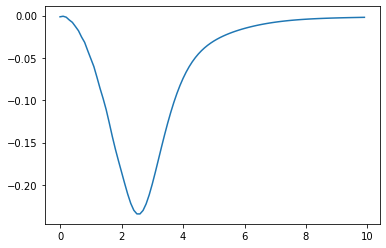

<Figure size 432x288 with 0 Axes>

In [94]:
plt.figure()
plt.plot(np.arange(0,10,0.1), Be(np.arange(0,10,0.1),*Be_Vpc_coeff_exp))
plt.figure()

In [164]:
Be_ESP_data = "/home/pmorenor/Desktop/PositronWork/Be/BeTotalESP.txt"

data = pd.read_csv(Be_ESP_data, delim_whitespace=True, engine="python", header=None)


r = data[0].astype(float)
r_Bohr = pd.Series([i*1.8897259886 for i in r])
V_Total = data[4].astype(float)

<Figure size 432x288 with 0 Axes>

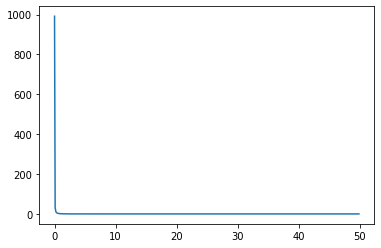

<Figure size 432x288 with 0 Axes>

In [165]:
plt.figure()
plt.plot(r_Bohr,V_Total)
plt.figure()

In [166]:
Be_Vpc_Bohr = [Be(i,*Be_Vpc_coeff_exp) for i in r_Bohr]

<Figure size 432x288 with 0 Axes>

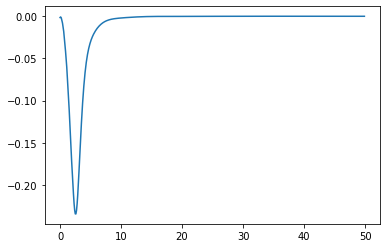

<Figure size 432x288 with 0 Axes>

In [167]:
plt.figure()
plt.plot(r_Bohr,Be_Vpc_Bohr)
plt.figure()

In [168]:
Vpc_ESP = [i+j for i,j in zip(V_Total,Be_Vpc_Bohr)]

<Figure size 432x288 with 0 Axes>

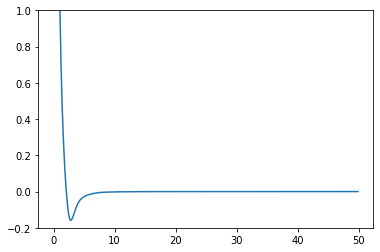

<Figure size 432x288 with 0 Axes>

In [169]:
plt.figure()
plt.plot(r_Bohr,Vpc_ESP)
plt.ylim(-0.2,1)
plt.figure()

### Now we are gonna fit the total potential ($V_{PC}+V_{ESP}$)

In [204]:
Fitting_parameters_Be_Vpc= create_parameters(9)
Be_gaussian_fitting = create_gaussians("BeTot",Fitting_parameters_Be_Vpc[0],Fitting_parameters_Be_Vpc[1],0)

In [236]:
popt, pcov = curve_fit(Be_gaussian_fitting, xdata=r_Bohr[15:100], ydata =Vpc_ESP[15:100], maxfev=50000)

print("Fitting parameters: \n")
print(popt_Vpcesp)
print("\n")
print("Error in fitting parameters: \n")
print(np.sqrt(np.diag(pcov_Vpcesp)))

Fitting parameters: 

[-4.53843822e-01 -1.44172583e+00 -1.81376469e+02 -1.91280953e+00
 -2.36171629e+00  1.80304960e+02 -6.55456258e-01 -1.67239234e-01
 -2.89237369e-01  4.64142091e+01  1.28200915e+01  6.50954218e-01
  1.41146757e-01  3.92017972e+00  6.46547452e-01  2.61865755e-02
  3.12644757e-04  4.24133828e-03]


Error in fitting parameters: 

[1.13359340e-01 1.72465925e-01 3.84804393e+05 3.45171112e-02
 1.47623865e-01 3.84804451e+05 6.47012062e-03 1.12339541e-03
 2.61555676e-03 9.75515673e+00 2.04933303e+00 4.70846673e+00
 2.09793389e-03 3.47794103e-01 4.68354693e+00 3.56839282e-04
 3.97864328e-06 5.72607480e-05]


2.799999438404665


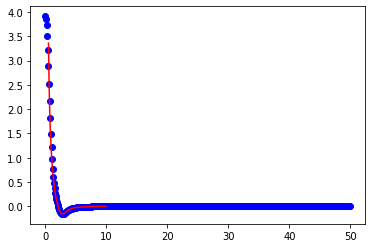

<Figure size 432x288 with 0 Axes>

In [245]:

plt.figure()
plt.plot(r_Bohr[5:100],Vpc_ESP[5:100], color = "red")
plt.scatter(r_Bohr, Be_gaussian_fitting(r_Bohr,*popt),color = "blue")
#plt.ylim(-0.175,0.0)
plt.figure()


FittedOne = list(Be_gaussian_fitting(r_Bohr,*popt))
FittedOne.index(min(FittedOne))

print(r_Bohr[28])

In [197]:
write_potential_to_lowdin_format("VPCESBE","E+",[int(0) for i in range(0,9)],np.split(popt_Vpcesp,2)[1],np.split(popt_Vpcesp,2)[0],[[0.0,0.0,0.0] for i in range(0,9)])
 

In [222]:
def nuclear_potential(r,Z=4):
    return Z/r

In [229]:
nucleus_contrib = nuclear_potential(r_Bohr)
Vpc_ESP_no_nucleus = [i+j-k for i,j,k in zip(V_Total[1:],Be_Vpc_Bohr[1:],nucleus_contrib[1:])]

In [230]:
popt_Vpcesp, pcov_Vpcesp = curve_fit(Be_gaussian_fitting, xdata=r_Bohr[1:], ydata =Vpc_ESP_no_nucleus, maxfev=50000)


<Figure size 432x288 with 0 Axes>

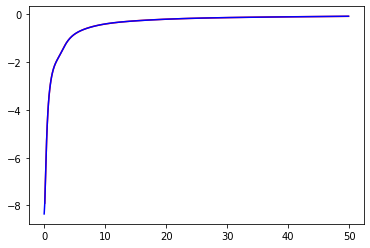

<Figure size 432x288 with 0 Axes>

In [232]:
plt.figure()
plt.plot(r_Bohr[1:],Vpc_ESP_no_nucleus, color = "red")
plt.plot(r_Bohr, Be_gaussian_fitting(r_Bohr,*popt_Vpcesp),color = "blue")
#plt.ylim(-0.175,0.0)
plt.figure()

In [233]:
write_potential_to_lowdin_format("EEBE","E+",[int(0) for i in range(0,9)],np.split(popt_Vpcesp,2)[1],np.split(popt_Vpcesp,2)[0],[[0.0,0.0,0.0] for i in range(0,9)])


In [234]:
write_potential_to_lowdin_format("TWOESBE","E+",[int(0) for i in range(0,9)],np.split(popt_Vpcesp,2)[1],np.split(popt_Vpcesp,2)[0],[[4.636,0.0,0.0] for i in range(0,9)])


In [235]:
join_lowdin_potentials("EEBE", "TWOESBE", "BEBETOT")
